In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Download latest version
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))

Using Colab cache for faster access to the 'exam-score-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/exam-score-prediction-dataset


In [37]:
# Add a classification column
df['at_risk'] = pd.cut(df['exam_score'],
                      bins=[-float('inf'), 59, float('inf')],
                      labels=[1, 0]).astype(int)

In [38]:
def metrics_calc(pred, y_test):
  # Convert probabilities to 0 or 1
  y_pred = (pred >= 0.5).astype(int)

  # Calculate outcomes
  tp = np.sum((y_pred == 1) & (y_test == 1)) # True Positives
  tn = np.sum((y_pred == 0) & (y_test == 0)) # True Negatives
  fp = np.sum((y_pred == 1) & (y_test == 0)) # False Positives
  fn = np.sum((y_pred == 0) & (y_test == 1)) # False Negatives

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  print(f"Precision: {precision:.2f}")
  print(f"Recall:    {recall:.2f}")
  print(f"F1 Score:  {f1:.2f}")

# Pipline

In [39]:
# Split the data
X = df.drop(columns=['student_id', 'exam_score', 'at_risk'])
y = df['at_risk']

# Define which columns get which treatment
binary_cols = ['internet_access']
categorical_cols = ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = np.asarray(X_train, dtype=np.float64)
# y_train = np.asarray(y_train, dtype=np.float64)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Create the Preprocessing Engine
preprocessor = ColumnTransformer(
    transformers=[
        # Maps 'no'/'yes' to 0/1 (OrdinalEncoder is cleaner than manual map here)
        ('binary', OrdinalEncoder(categories=[['no', 'yes']]), binary_cols),
        # Handles your One-Hot Encoding with drop_first logic
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough' # Keeps any numerical columns not specified
)

# Create the Full Pipeline (Preprocessing + Scaling + Model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One single call fits everything
pipeline.fit(X_train, y_train)

# Predict and Evaluate
y_pred = pipeline.predict(X_test)

(16000, 11) (4000, 11)
(16000,) (4000,)


In [41]:
print(f'Accuracy: {(y_pred.round().astype(int) == y_test).mean() * 100:.2f}%')

metrics_calc(y_pred, y_test)

Accuracy: 83.35%
Precision: 0.81
Recall:    0.81
F1 Score:  0.81


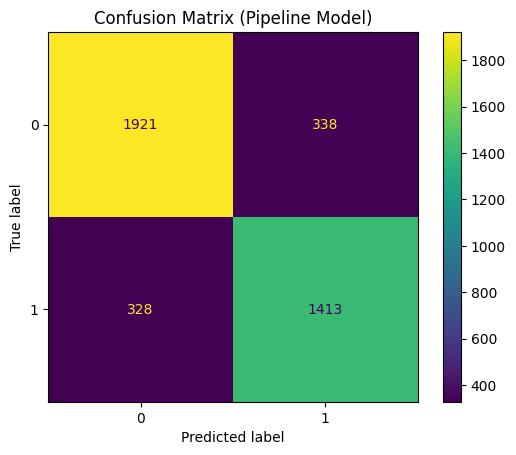

In [42]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.title("Confusion Matrix (Pipeline Model)")
plt.show()